In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
import fitsio
from tqdm import tqdm

from astroquery.jplhorizons import Horizons
from sbident import SBIdent

from tess_ephem import ephem, TessEphem, log
from tess_asteroid_ml import *
from tess_asteroid_ml.utils import *
from tess_asteroid_ml.make_TESS_asteroid_db import *
# from ipywidgets import *

In [3]:
url = "https://archive.stsci.edu/missions/tess/ffi/s0004/2018/307/1-1/tess2018307065939-s0004-1-1-0124-s_ffic.fits"

In [4]:
maglim = 22

In [5]:
PACKAGEDIR

'/Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/tess_asteroid_ml'

['https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/1-1/tess2018361042937-s0006-1-1-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/1-2/tess2018361042937-s0006-1-2-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/1-3/tess2018361042937-s0006-1-3-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/1-4/tess2018361042937-s0006-1-4-0126-s_ffic.fits']
Loading from CSV file...
Asteroid catalog shape (V < 22):  (14535, 23)


 ... (more hidden) ...


Asteroid tracks in DB: 13893
Ploting figure...


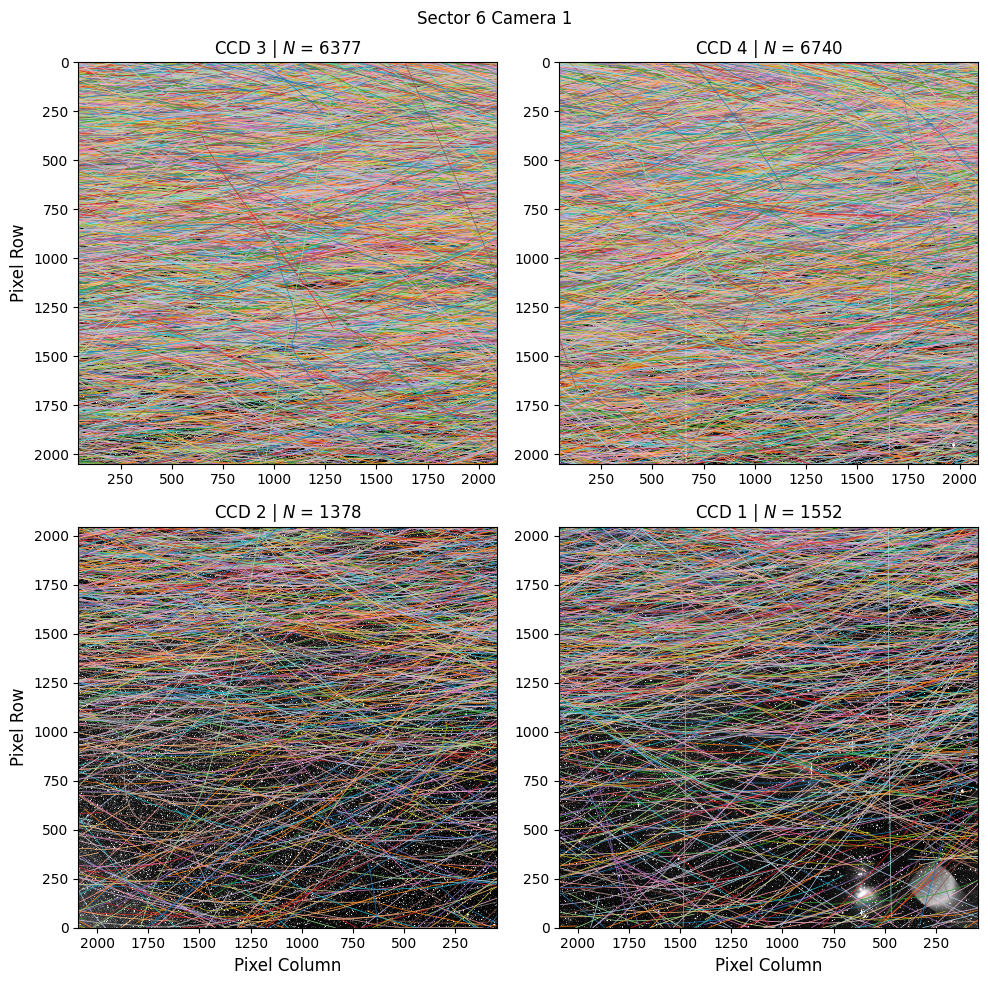

['https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/2-1/tess2018361042937-s0006-2-1-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/2-2/tess2018361042937-s0006-2-2-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/2-3/tess2018361042937-s0006-2-3-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/2-4/tess2018361042937-s0006-2-4-0126-s_ffic.fits']
Loading from CSV file...
Asteroid catalog shape (V < 22):  (1147, 23)


 ... (more hidden) ...


Asteroid tracks in DB: 1020
Ploting figure...


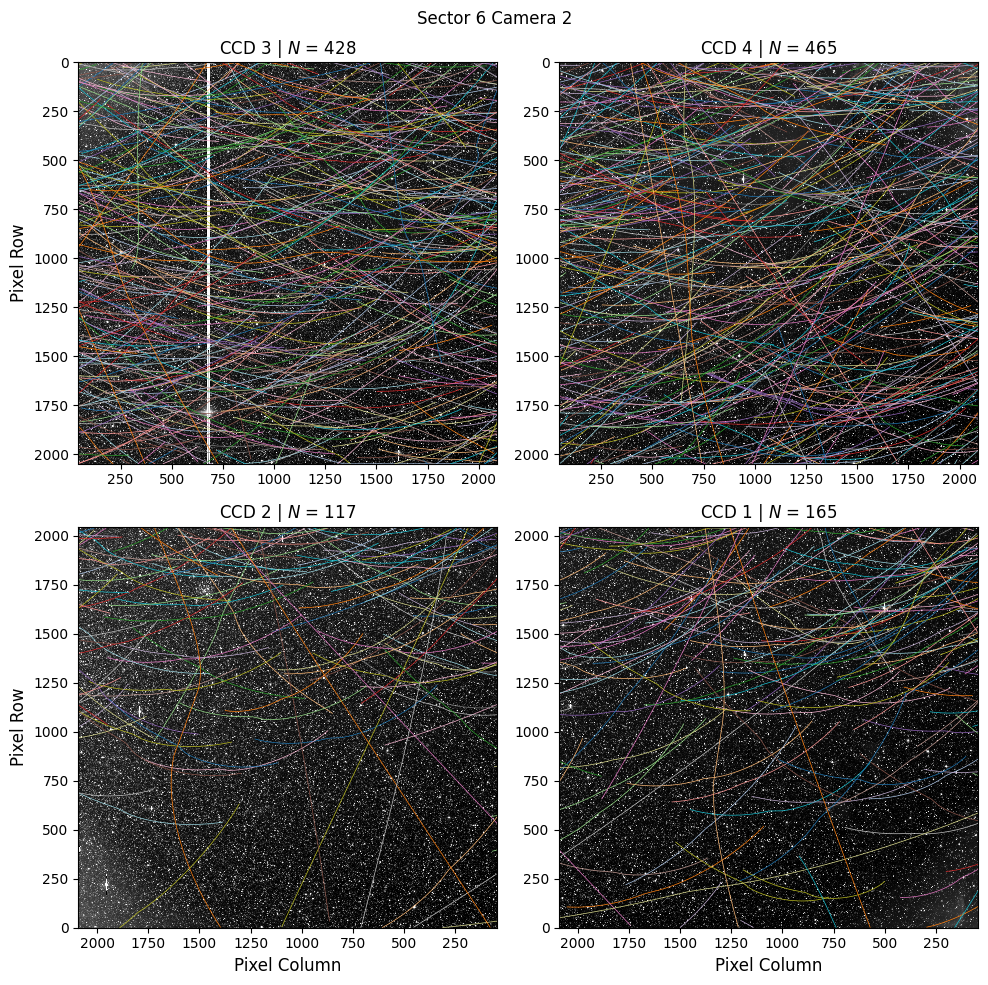

['https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/3-1/tess2018361042937-s0006-3-1-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/3-2/tess2018361042937-s0006-3-2-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/3-3/tess2018361042937-s0006-3-3-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/3-4/tess2018361042937-s0006-3-4-0126-s_ffic.fits']
Loading from CSV file...
Asteroid catalog shape (V < 22):  (92, 23)


 ... (more hidden) ...

Asteroid tracks in DB: 60
Ploting figure...


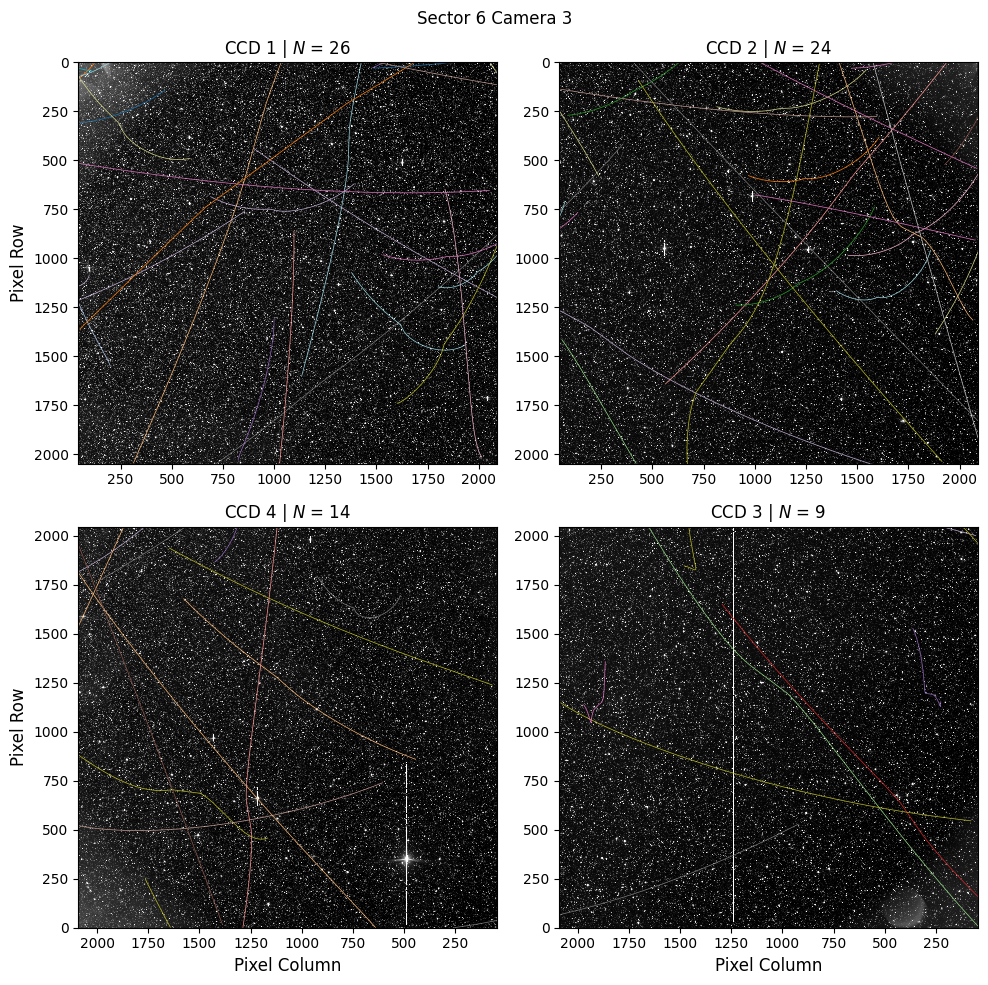

['https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/4-1/tess2018361042937-s0006-4-1-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/4-2/tess2018361042937-s0006-4-2-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/4-3/tess2018361042937-s0006-4-3-0126-s_ffic.fits', 'https://archive.stsci.edu/missions/tess/ffi/s0006/2018/361/4-4/tess2018361042937-s0006-4-4-0126-s_ffic.fits']
Loading from CSV file...
Asteroid catalog shape (V < 22):  (72, 23)


 ... (more hidden) ...

Asteroid tracks in DB: 17
Ploting figure...


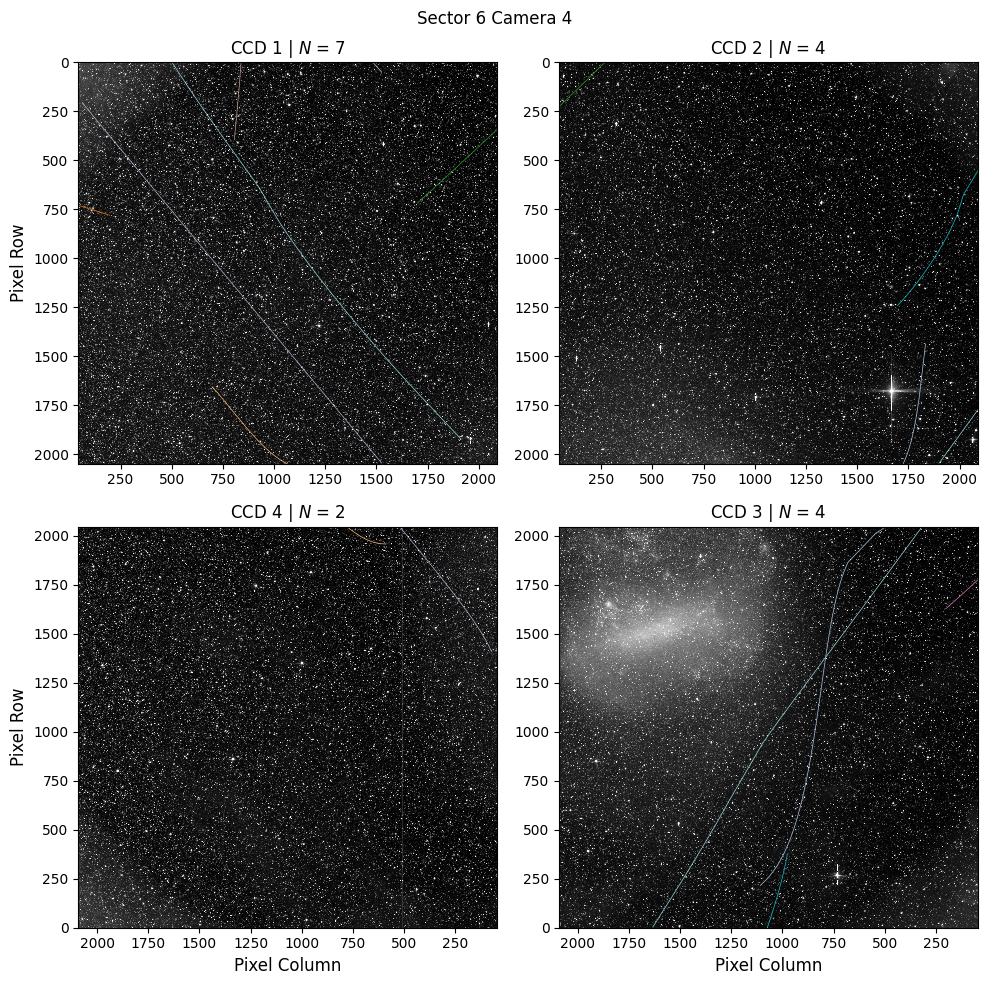

In [53]:
for sector in range(6, 7):
    for camera in range(1, 5):
        ffi_file = get_FFI_name(sector=sector, camera=camera, ccd=0, correct=False)
        print(ffi_file)
    
        with fits.open(ffi_file[0]) as ffi:
            date_obs = Time([ffi[0].header["DATE-OBS"], ffi[0].header["DATE-END"]])
    
        COL, ROW, F = {}, {}, {}
        for k, ccd in enumerate(range(1,5)):
            col_2d, row_2d, f2d = load_ffi_image(
                            "TESS",
                            ffi_file[k],
                            1,
                            None,
                            [0, 0],
                            return_coords=True,
                        )
        
            COL[ccd] = col_2d
            ROW[ccd] = row_2d
            F[ccd] = f2d
    
        scc_str = f"s{sector:04}-{camera}-{0}"
    
        jpl_sbi_file = (f"{os.path.dirname(PACKAGEDIR)}/data/jpl"
                        f"/jpl_small_bodies_tess_{scc_str}_catalog.csv")    
        if os.path.isfile(jpl_sbi_file):
            print("Loading from CSV file...")
            jpl_sb = pd.read_csv(jpl_sbi_file, index_col=0)
    
        jpl_sb_bright = jpl_sb.query(f"V_mag <= {maglim}").reset_index()
        print(f"Asteroid catalog shape (V < {maglim}): ", jpl_sb_bright.shape)
    
        sb_ephems_lowres = {}
        track_color = {}
    
        for k, row in tqdm(jpl_sb_bright.iterrows(), total=len(jpl_sb_bright)):
            
            feath_file = (f"{os.path.dirname(PACKAGEDIR)}/data/jpl/tracks/sector{sector:04}/"
                          f"tess-ffi_s{sector:04}-0-0_{row['id'].replace(' ', '-')}_hires.feather")
            if os.path.isfile(feath_file):
                ephems_aux = pd.read_feather(feath_file)
                step = len(ephems_aux) // 27 - 1 if len(ephems_aux) > 100 else 4
                sb_ephems_lowres[k] = ephems_aux
                track_color[k] = plt.cm.tab20(np.random.randint(0,20))
    
        print(f"Asteroid tracks in DB: {len(sb_ephems_lowres)}")

        print("Ploting figure...")
        fig, ax = plt.subplots(2, 2, figsize=(10,10))
        plt.suptitle(f"Sector {sector} Camera {camera}", y=0.98, fontsize="large")
        
        for k, ccd in enumerate(range(1,5)):
            if camera in [1, 2]:
                if ccd == 1:
                    ax_ = ax[1, 1]
                    ax_.invert_xaxis()
                    ax_.set_xlim(2091, 44)
                    ax_.set_ylim(0, 2047)
                elif ccd == 2:
                    ax_ = ax[1, 0]
                    ax_.invert_xaxis()
                    ax_.set_xlim(2091, 44)
                    ax_.set_ylim(0, 2047)
                elif ccd == 3:
                    ax_ = ax[0, 0]
                    ax_.invert_yaxis()
                    ax_.set_xlim(44, 2091)
                    ax_.set_ylim(2047, 0)
                elif ccd == 4:
                    ax_ = ax[0, 1]
                    ax_.invert_yaxis()
                    ax_.set_xlim(44, 2091)
                    ax_.set_ylim(2047, 0)
        
            if camera in [3, 4]:
                if ccd == 1:
                    ax_ = ax[0, 0]
                    ax_.invert_yaxis()
                    ax_.set_xlim(44, 2091)
                    ax_.set_ylim(2047, 0)
                elif ccd == 2:
                    ax_ = ax[0, 1]
                    ax_.invert_yaxis()
                    ax_.set_xlim(44, 2091)
                    ax_.set_ylim(2047, 0)
                elif ccd == 3:
                    ax_ = ax[1, 1]
                    ax_.invert_xaxis()
                    ax_.set_xlim(2091, 44)
                    ax_.set_ylim(0, 2047)
                elif ccd == 4:
                    ax_ = ax[1, 0]
                    ax_.invert_xaxis()
                    ax_.set_xlim(2091, 44)
                    ax_.set_ylim(0, 2047)
        
            vlo, lo, mid, hi, vhi = np.nanpercentile(F[ccd], [0.2, 1, 50, 95, 99.8])
            cnorm = colors.LogNorm(vmin=lo, vmax=vhi)
            ax_.pcolormesh(COL[ccd], ROW[ccd], F[ccd], 
                           norm=cnorm, cmap="Greys_r", 
                           rasterized=True)
            
            counter = 0
            for i, (k, val) in enumerate(sb_ephems_lowres.items()):
                if len(val) == 0:
                    continue
                val = val.query(f"camera == {camera} and ccd == {ccd}")
                if len(val) > 0: 
                    counter += 1
                    ax_.plot(val.column, val.row, "-", lw=.5, rasterized=True, c=track_color[k])
                # if i == 10: break
            
            ax_.set_title(f"CCD {ccd} | $N$ = {counter}", fontsize="large")
        
            # ax_.axis('equal')
        
        ax[1,0].set_xlabel("Pixel Column", fontsize="large")
        ax[1,1].set_xlabel("Pixel Column", fontsize="large")
        ax[0,0].set_ylabel("Pixel Row", fontsize="large")
        ax[1,0].set_ylabel("Pixel Row", fontsize="large")

        dir_name = f"{os.path.dirname(PACKAGEDIR)}/data/figures/asteroid_tracks"
        if not os.path.isdir(dir_name):
            os.makedirs(dir_name)
        dir_name = (
            f"{dir_name}/tess_ffi_s{sector:04}-{camera}-all_asteroid_tracks.pdf"
        )
        fig.tight_layout()
        plt.savefig(dir_name, bbox_inches="tight")
        
        plt.show()

        # break

In [37]:
from matplotlib import colors
import matplotlib.cm as cm

In [47]:
plt.cm.tab20(np.random.randint(0,20))

(0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0)

In [41]:
len(sb_ephems_lowres)

1020

In [43]:
cls = cm.tab20(np.arange(len(sb_ephems_lowres)))
cls

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.68235294, 0.78039216, 0.90980392, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       ...,
       [0.61960784, 0.85490196, 0.89803922, 1.        ],
       [0.61960784, 0.85490196, 0.89803922, 1.        ],
       [0.61960784, 0.85490196, 0.89803922, 1.        ]])